In [90]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import random


In [91]:
from qiskit.quantum_info import Pauli
from itertools import product

# create n-qubit pauli operator set using cartesian product
def create_pauli(ndim):
    pauli_set = []
    for i in product(['I', 'X', 'Y', 'Z'], repeat=ndim):
        pauli_set.append(Pauli(''.join(i)))
    
    assert not(ndim==1) or len(pauli_set) == 4
    assert not(ndim ==2) or len(pauli_set) == 16

    return pauli_set

# # create 2-qubit pauli operator set
# pauli_set = create_pauli(ndim)

In [92]:
import numpy as np
from qiskit.quantum_info import random_clifford
from qiskit.quantum_info import Statevector
from functools import lru_cache

cache = lru_cache(maxsize=None)
@cache
def create_stabilizer_set(ndim):
    """Monte-Carlo approach, set of states from random clifford group.
    By definition, the stabilizer states are created by Clifford gates acting on |0\>^{otimes n}
    """
    N_cliff = max(2,ndim)**8 # defines the number of random Clifford circuits to generate
    # NOTE increase until len(stabilizer_set) converges

    stabilizer_set = []
    for i in range(N_cliff):
        # run random clifford 
        qc = QuantumCircuit(ndim)
        qc.append(random_clifford(ndim), range(ndim))
        # circuit to state
        state = Statevector.from_instruction(qc)
        # append to set
        stabilizer_set.append(state)
        # print(state)
    
    # drop duplicates (up to a global phase)
    # use Statevector.equiv to check if two states are equivalent
    for i in range(len(stabilizer_set)):
        if stabilizer_set[i] is None:
            continue
        for j in range(i+1, len(stabilizer_set)):
            if stabilizer_set[j] is None:
                continue
            if stabilizer_set[i].equiv(stabilizer_set[j]):
                stabilizer_set[j] = None
    stabilizer_set = [x for x in stabilizer_set if x is not None]
    
    assert not(ndim==1) or len(stabilizer_set) == 6
    # for more than ndim, idk how many stabilizer states there are
    return stabilizer_set

# %timeit create_stabilizer_set(ndim)

The optimization can be written in terms of a linear system as $$\mathcal{R}(\rho) = \min || x ||_1 \text{ subject to } Ax = b$$, where $||x||_1 = \sum_i |x_i|$, $b_i = \mathrm{Tr}{(P_i \rho)}$, and $A_{j,i} = \mathrm{Tr}{(P_j \sigma_i)}$ where $P_j$ is the $j$-th Pauli operator.

In [115]:
# Reference: https://arxiv.org/abs/1609.07488

def construct_A(ndim, pauli_set=None):
    """Constructs the A matrix for the stabilizer states
    """
    if pauli_set is None:
        pauli_set = create_pauli(ndim)
    stabilizer_set = create_stabilizer_set(ndim)
    A = np.zeros((len(pauli_set), len(stabilizer_set)), dtype=complex)
    for i, state in enumerate(stabilizer_set):
        for j, pauli in enumerate(pauli_set):
            A[j,i] = state.expectation_value(pauli)
    return A

def construct_B(statevector, pauli_set=None, ndim=None):
    """Constructs the B matrix for the statevector
    """
    if pauli_set is None:
        assert ndim is not None
        pauli_set = create_pauli(ndim)
    B = np.zeros((len(pauli_set),), dtype=complex)
    for j, pauli in enumerate(pauli_set):
        B[j] = statevector.expectation_value(pauli)
    return B

# construct_A(1)
# construct_B(Statevector.from_label('0'))

In [94]:
import cvxpy as cp
# NOTE use cvxpy because nonunique solution
# we could solve Ax = b using numpy.linalg.lstsq
# x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

def robustness_of_magic(statevector) -> float:
    """Compute the robustness of a statevector"""
    # first determine size of problem
    ndim = int(np.log2(len(statevector)))
    if ndim > 2:
        raise ValueError("ndim too big, current implementation too slow")
    pauli_set = create_pauli(ndim)

    # second construct the A matrix and b vector
    A = construct_A(ndim, pauli_set)
    b = construct_B(statevector, pauli_set)

    # now solve the optimization problem 
    # min ||x||_1 s.t. Ax = b
    x = cp.Variable(len(A[0]))
    objective = cp.Minimize(cp.norm(x,1))
    constraints = [A @ x == b]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return prob.value

# now we can compute the robustness of the magic state
H = Statevector([1,np.exp(1j * np.pi/4)])/np.sqrt(2)
# H.draw('bloch')

# verify correctness of 1-qubit case
rH = robustness_of_magic(H)
print(rH)
assert np.isclose(rH, np.sqrt(2))

# verify correctness of 2-qubit case
H2 = H.tensor(H)
rH2 = robustness_of_magic(H2)
print(rH2)
assert np.isclose(rH2, (1 + 3*np.sqrt(2))/3)

# verify correctness of 3-qubit case
# scales so poorly :(
# H3 = H2.tensor(H)
# rH3 = robustness_of_magic(H3)
# print(rH3)
# assert np.isclose(rH3, (1 + 4*np.sqrt(2))/3)

1.4142135626928558
1.747546895825713


In [95]:
def robustness_to_gadgets(r, tolerance=0.1):
    thresholds = [1.4142, 1.7476, 2.2190, 2.8627, 3.68705]
    for i, threshold in enumerate(thresholds):
        if r <= threshold + 1e-6:
            return i 

In [96]:
# what is the robustness of CX?
def gate_gadgets(qc):
    # convert qc to statevector

    # by definition, apply U to |+>^{otimes n} to  get |U>
    # preprend Hadamard gates to qc
    h_prep = QuantumCircuit(qc.num_qubits)
    for i in range(qc.num_qubits):
        h_prep.h(i)
    qc = h_prep.compose(qc)

    statevector = Statevector.from_instruction(qc)
    # compute robustness
    r = robustness_of_magic(statevector)
    logging.debug("Robustness of Magic:", r)
    g = robustness_to_gadgets(r)
    logging.debug("Minimal # of gadgets:", g)
    return r, g

In [97]:
from qiskit.circuit.library import *
qc = QuantumCircuit(2)
# qc.append(CSGate(), [0,1])
qc.append(CXGate(), [0,1])
r, g = gate_gadgets(qc)

In [98]:
# next we can test how many gadgets would be used in qiskit implementations of gates
# gadget decompositions are known for t, tdg, ccx, u1
extended_stabilizer_simulator = AerSimulator(method='extended_stabilizer')
from qiskit.quantum_info import random_unitary
# transpile to CX and T
qc = QuantumCircuit(2)
qc.append(random_unitary(4), [0,1])
transp_qc = transpile(qc, extended_stabilizer_simulator)
r, g = gate_gadgets(qc)

In [113]:
# repeat # of gadgets many times and plot r, h histograms
r_list = []
g_list = []
for i in range(250):
    qc = QuantumCircuit(2)
    qc.append(random_unitary(4), [0,1])
    transp_qc = transpile(qc, extended_stabilizer_simulator)
    r, g = gate_gadgets(qc)
    r_list.append(r)
    g_list.append(g)

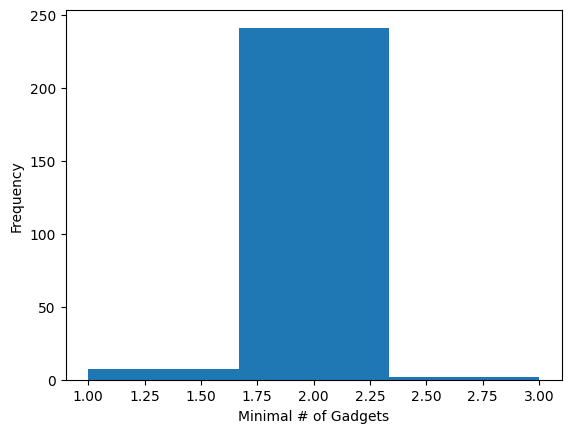

In [114]:
import matplotlib.pyplot as plt
# plt.hist(r_list, bins=10)
# plt.xlabel('Robustness of Magic')
# plt.ylabel('Frequency')

plt.hist(g_list, bins=3)
plt.xlabel('Minimal # of Gadgets')
plt.ylabel('Frequency')
plt.show()

In [100]:
# TODO
# now we want to know if there is a gate that uses more ancillas than optimal when decomposed using CX gates



In [116]:
transp_qc.draw()

global phase: 2.7199
      ┌────────────┐┌────┐ ┌────────────┐┌────┐┌────────────┐    ┌────────┐»
q_0: ─┤ P(-2.3203) ├┤ √X ├─┤ P(-2.5275) ├┤ √X ├┤ P(0.88645) ├─■──┤ P(π/2) ├»
     ┌┴────────────┤├────┤┌┴────────────┤├────┤├────────────┤ │ ┌┴────────┤»
q_1: ┤ P(-0.27737) ├┤ √X ├┤ P(-0.97481) ├┤ √X ├┤ P(0.49326) ├─■─┤ P(-π/2) ├»
     └─────────────┘└────┘└─────────────┘└────┘└────────────┘   └─────────┘»
«     ┌────┐┌────────────┐┌────┐┌────────┐   ┌─────────┐┌────┐┌────────────┐»
«q_0: ┤ √X ├┤ P(-2.6312) ├┤ √X ├┤ P(π/2) ├─■─┤ P(-π/2) ├┤ √X ├┤ P(-3.0857) ├»
«     ├────┤├────────────┤└────┘└────────┘ │ └┬────────┤├────┤└────────────┘»
«q_1: ┤ √X ├┤ P(-1.4292) ├─────────────────■──┤ P(π/2) ├┤ √X ├──────────────»
«     └────┘└────────────┘                    └────────┘└────┘              »
«     ┌────┐   ┌────────────┐┌────┐ ┌───────────┐ ┌────┐┌───────────┐
«q_0: ┤ √X ├─■─┤ P(-0.7745) ├┤ √X ├─┤ P(-1.439) ├─┤ √X ├┤ P(1.0411) ├
«     └────┘ │ ├────────────┤├────┤┌┴───────────┴┐├────┤├───────────┤
«q_1: ───────■─┤ P(-1.6811) ├┤ √X ├┤ P(-0.31475) ├┤ √X ├┤ P(1.2595) ├
«              └────────────┘└────┘└─────────────┘└────┘└───────────┘